Deep Learning-->Solar Panel Defect Detection

In [1]:
# project setup & paths

import os, warnings, platform, gc, random, zipfile, shutil, math
from pathlib import Path

warnings.filterwarnings("ignore")

os.environ.setdefault("OMP_NUM_THREADS", "4")
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# project folders under the current working directory
PROJECT_ROOT = Path.cwd() / "solar_guard"
DATA_ROOT    = PROJECT_ROOT / "data"
RAW_DIR      = DATA_ROOT / "raw"          
SPLIT_DIR    = DATA_ROOT / "splits"      
REPORTS      = PROJECT_ROOT / "reports" / "figures"
ARTIFACTS    = PROJECT_ROOT / "artifacts"

for p in [PROJECT_ROOT, DATA_ROOT, RAW_DIR, SPLIT_DIR, REPORTS, ARTIFACTS]:
    p.mkdir(parents=True, exist_ok=True)

# data set path
ZIP_DIR = Path(r"D:\Data Science - py")

print("python:", platform.python_version())
print("project root:", PROJECT_ROOT)
print("zip dir exists:", ZIP_DIR.exists())


python: 3.11.9
project root: D:\Data Science - py\solar_guard
zip dir exists: True


In [2]:
import torch, torchvision
from torch import nn
from torchvision import transforms, datasets

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("cuda available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

x = torch.randn(3, 3)
print("probe mean:", x.mean().item())
del x; gc.collect();

torch: 2.8.0+cpu
torchvision: 0.23.0+cpu
cuda available: False
using device: cpu
probe mean: -0.5654006600379944


In [3]:
# pick the most relevant/most recent zip in D:\Data Science - py

ZIP_PATH = Path(r"D:\Data Science - py\Faulty_solar_panel-20250820T164359Z-1-001.zip")
if ZIP_DIR.exists():
    zips = sorted(ZIP_DIR.glob("*.zip"), key=lambda p: p.stat().st_mtime, reverse=True)
    if zips:
        preferred = [p for p in zips if "fault" in p.name.lower() or "solar" in p.name.lower()]
        ZIP_PATH = preferred[0] if preferred else zips[0]

print("selected zip:", ZIP_PATH)

def safe_extract(zip_fp: Path, dest: Path):
    if not zip_fp or not zip_fp.exists():
        print("zip not found. set ZIP_PATH manually if needed.")
        return
    if not any(dest.iterdir()):
        with zipfile.ZipFile(zip_fp, "r") as zf:
            zf.extractall(dest)
        print("extracted to:", dest)
    else:
        print("data/raw not empty → skipping extract")

safe_extract(ZIP_PATH, RAW_DIR)

# finding the top folder we just extracted
DATASET_TOP = None
for d in RAW_DIR.iterdir():
    if d.is_dir():
        DATASET_TOP = d
        break

if DATASET_TOP is None:
    raise RuntimeError("No dataset folder found under data/raw. Put the class folders or the zip there and rerun.")

print("dataset top:", DATASET_TOP)

# removing junk files that comes from Windows
JUNK = {"desktop.ini", "Thumbs.db", ".DS_Store"}
removed = 0
for p in DATASET_TOP.rglob("*"):
    if p.is_file() and p.name in JUNK:
        p.unlink(); removed += 1
print("junk removed:", removed)

# flattening Bird-drop/New if present
bd_new = DATASET_TOP / "Bird-drop" / "New"
if bd_new.exists() and bd_new.is_dir():
    moved = 0
    for q in bd_new.iterdir():
        if q.is_file():
            shutil.move(str(q), str(bd_new.parent / q.name)); moved += 1
    shutil.rmtree(bd_new)
    print(f"flattened Bird-drop/New (moved {moved})")

# normalising class folder names to clean identifiers
RENAME = {
    "Clean": "Clean",
    "Dusty": "Dusty",
    "Bird-drop": "BirdDrop",
    "Electrical-damage": "ElectricalDamage",
    "Physical-Damage": "PhysicalDamage",
    "Snow-Covered": "SnowCovered",
}
for old, new in RENAME.items():
    src, dst = DATASET_TOP/old, DATASET_TOP/new
    if src.exists() and src != dst:
        if dst.exists():
            for f in src.iterdir():
                shutil.move(str(f), str(dst/f.name))
            shutil.rmtree(src)
        else:
            src.rename(dst)

classes = sorted([d.name for d in DATASET_TOP.iterdir() if d.is_dir()])
print("classes:", classes)

selected zip: D:\Data Science - py\Faulty_solar_panel-20250820T164359Z-1-001.zip
extracted to: D:\Data Science - py\solar_guard\data\raw
dataset top: D:\Data Science - py\solar_guard\data\raw\Faulty_solar_panel
junk removed: 6
flattened Bird-drop/New (moved 16)
classes: ['BirdDrop', 'Clean', 'Dusty', 'ElectricalDamage', 'PhysicalDamage', 'SnowCovered']


In [4]:
from PIL import Image

def is_img(p: Path):
    return p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

per_class_files, bad = {}, []
for cls in classes:
    folder = DATASET_TOP / cls
    files = [p for p in folder.iterdir() if p.is_file() and is_img(p)]
    per_class_files[cls] = sorted(files)
    
    for p in files[:5]:
        try:
            with Image.open(p) as im:
                im.verify()
        except Exception as e:
            bad.append((str(p), str(e)))

counts = {k: len(v) for k, v in per_class_files.items()}
print("per-class counts:", counts, "| total:", sum(counts.values()))

if bad:
    print("unreadable images:", len(bad), "→ removing")
    for path, _ in bad:
        Path(path).unlink(missing_ok=True)

per-class counts: {'BirdDrop': 207, 'Clean': 193, 'Dusty': 190, 'ElectricalDamage': 103, 'PhysicalDamage': 69, 'SnowCovered': 123} | total: 885


In [5]:
# 80/20 split--> Training and Testing

from sklearn.model_selection import train_test_split

SEED = 42
train_ratio, test_ratio = 0.8, 0.2
val_within_train = 0.10   # 10% of train becomes validation (~8% of total)

# wipe and recreate split dirs to avoid leftover files
for split in ["train", "val", "test"]:
    for c in classes:
        dst = SPLIT_DIR / split / c
        if dst.exists():
            for f in dst.iterdir():
                if f.is_file():
                    f.unlink()
        else:
            dst.mkdir(parents=True, exist_ok=True)

def copy_all(files, dest):
    for f in files:
        shutil.copy2(f, dest / f.name)

summary = {}
for c in classes:
    files = [p for p in (DATASET_TOP / c).iterdir() if p.is_file() and is_img(p)]
    # 80/20 train/test
    train_all, test_files = train_test_split(
        files, test_size=test_ratio, random_state=SEED, shuffle=True
    )
    # validation from the training 
    val_size = max(1, int(len(train_all) * val_within_train)) if len(train_all) > 10 else 1
    train_files, val_files = train_test_split(
        train_all, test_size=val_size, random_state=SEED, shuffle=True
    )

    copy_all(train_files, SPLIT_DIR / "train" / c)
    copy_all(val_files,   SPLIT_DIR / "val"   / c)
    copy_all(test_files,  SPLIT_DIR / "test"  / c)

    summary[c] = {"train": len(train_files), "val": len(val_files), "test": len(test_files)}

summary

{'BirdDrop': {'train': 149, 'val': 16, 'test': 42},
 'Clean': {'train': 139, 'val': 15, 'test': 39},
 'Dusty': {'train': 137, 'val': 15, 'test': 38},
 'ElectricalDamage': {'train': 74, 'val': 8, 'test': 21},
 'PhysicalDamage': {'train': 50, 'val': 5, 'test': 14},
 'SnowCovered': {'train': 89, 'val': 9, 'test': 25}}

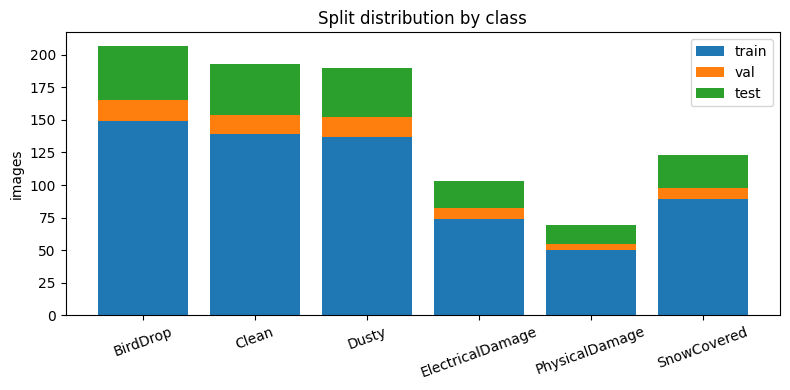

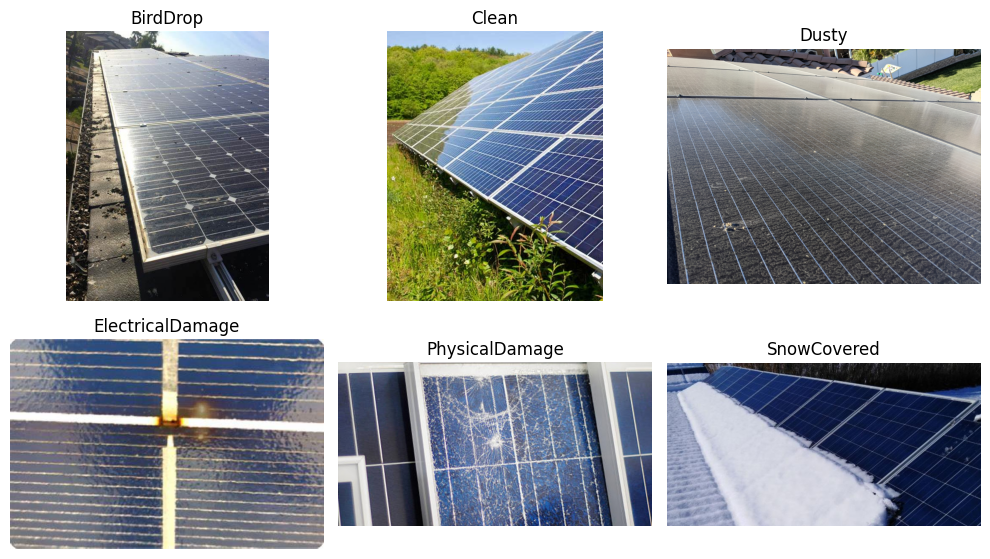

In [6]:
# EDA: split distribution & quick sample grid

import matplotlib.pyplot as plt
import numpy as np
import random

cls = list(summary.keys())
tr  = [summary[c]["train"] for c in cls]
va  = [summary[c]["val"]   for c in cls]
te  = [summary[c]["test"]  for c in cls]

plt.figure(figsize=(8,4))
x = np.arange(len(cls))
plt.bar(x, tr, label="train")
plt.bar(x, va, bottom=tr, label="val")
plt.bar(x, te, bottom=(np.array(tr) + np.array(va)), label="test")
plt.xticks(x, cls, rotation=20)
plt.ylabel("images")
plt.title("Split distribution by class")
plt.legend(); plt.tight_layout(); plt.show()

# showing one random image per class from training
ncols, nrows = 3, int(np.ceil(len(cls) / 3))
plt.figure(figsize=(10, 3*nrows))
for i, c in enumerate(cls, 1):
    pool = [p for p in (SPLIT_DIR/"train"/c).iterdir() if is_img(p)]
    if not pool: 
        continue
    img = Image.open(random.choice(pool)).convert("RGB")
    plt.subplot(nrows, ncols, i)
    plt.imshow(img); plt.axis("off"); plt.title(c)
plt.tight_layout(); plt.show()

In [7]:
# datasets & dataloaders (resizing & normalizing)

from torchvision import transforms, datasets

IMG_SIZE   = 224
BATCH_SIZE = 16  

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

train_ds = datasets.ImageFolder(SPLIT_DIR/"train", transform=train_tfms)
val_ds   = datasets.ImageFolder(SPLIT_DIR/"val",   transform=eval_tfms)
test_ds  = datasets.ImageFolder(SPLIT_DIR/"test",  transform=eval_tfms)

idx_to_class = {v: k for k, v in train_ds.class_to_idx.items()}
print("class_to_idx:", train_ds.class_to_idx)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

xb, yb = next(iter(train_loader))
print("batch shapes:", xb.shape, yb.shape)
del xb, yb; gc.collect();

class_to_idx: {'BirdDrop': 0, 'Clean': 1, 'Dusty': 2, 'ElectricalDamage': 3, 'PhysicalDamage': 4, 'SnowCovered': 5}
batch shapes: torch.Size([16, 3, 224, 224]) torch.Size([16])


In [8]:
from torchvision.models import (
    mobilenet_v3_small, MobileNet_V3_Small_Weights,
    efficientnet_b0, EfficientNet_B0_Weights,
    resnet50, ResNet50_Weights
)

def make_model(name: str, num_classes: int):
    name = name.lower()
    if name == "mobilenet_v3":
        w = MobileNet_V3_Small_Weights.IMAGENET1K_V1
        m = mobilenet_v3_small(weights=w)
        in_feats = m.classifier[3].in_features
        m.classifier[3] = nn.Linear(in_feats, num_classes)
        return m
    if name == "efficientnet_b0":
        w = EfficientNet_B0_Weights.IMAGENET1K_V1
        m = efficientnet_b0(weights=w)
        in_feats = m.classifier[1].in_features
        m.classifier[1] = nn.Linear(in_feats, num_classes)
        return m
    if name == "resnet50":
        w = ResNet50_Weights.IMAGENET1K_V2
        m = resnet50(weights=w)
        in_feats = m.fc.in_features
        m.fc = nn.Linear(in_feats, num_classes)
        return m
    raise ValueError("unknown model name")

num_classes = len(train_ds.classes)
model_name  = "mobilenet_v3"   
model = make_model(model_name, num_classes).to(device)

# fine tuning
for p in model.parameters():
    p.requires_grad = True

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{model_name} → trainable params: {trainable/1e6:.2f}M on {device}")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\deepa/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth


100%|█████████████████████████████████████████████████████████████████████████████| 9.83M/9.83M [00:10<00:00, 1.01MB/s]


mobilenet_v3 → trainable params: 1.52M on cpu


In [9]:
from collections import Counter
from sklearn.metrics import f1_score
from tqdm import tqdm
import numpy as np

# building class weights from training samples
targets = [lbl for _, lbl in train_ds.samples]
count_by_idx = Counter(targets)
max_count = max(count_by_idx.values())
weights = [max_count / count_by_idx[i] for i in range(num_classes)]
class_weights = torch.tensor(weights, dtype=torch.float32, device=device)
print("class_counts:", dict(count_by_idx))
print("class_weights:", [round(w, 2) for w in weights])

LR = 3e-4
EPOCHS = 20
PATIENCE = 5

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

def run_epoch(net, loader, train=False):
    net.train(train)
    total_loss = 0.0
    y_true, y_pred = [], []

    with torch.set_grad_enabled(train):
        for xb, yb in tqdm(loader, leave=False):
            xb, yb = xb.to(device), yb.to(device)
            if train:
                optimizer.zero_grad(set_to_none=True)
            out = net(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            if train:
                loss.backward()
                optimizer.step()
            preds = out.argmax(1)
            y_true.extend(yb.detach().cpu().tolist())
            y_pred.extend(preds.detach().cpu().tolist())
            del xb, yb, out, preds, loss
        gc.collect()

    avg_loss = total_loss / len(loader.dataset)
    f1m = f1_score(y_true, y_pred, average="macro")
    return avg_loss, f1m

best_f1, best_state, patience = -1, None, 0
history = []

for ep in range(1, EPOCHS+1):
    tr_loss, tr_f1 = run_epoch(model, train_loader, train=True)
    va_loss, va_f1 = run_epoch(model, val_loader,   train=False)
    scheduler.step()

    history.append({"epoch": ep, "train_loss": tr_loss, "train_f1": tr_f1,
                             "val_loss": va_loss,   "val_f1": va_f1})
    print(f"epoch {ep:02d} | train {tr_loss:.4f}/{tr_f1:.4f} | val {va_loss:.4f}/{va_f1:.4f}")

    if va_f1 > best_f1:
        best_f1 = va_f1
        best_state = {
            "model": model.state_dict(),
            "class_to_idx": train_ds.class_to_idx,
            "val_f1": float(va_f1),
            "model_name": model_name,
        }
        torch.save(best_state, ARTIFACTS / "best_classifier.pt")
        patience = 0
    else:
        patience += 1
        if patience >= PATIENCE:
            print("early stopping.")
            break

print("best val F1:", round(best_f1, 4))

class_counts: {0: 149, 1: 139, 2: 137, 3: 74, 4: 50, 5: 89}
class_weights: [1.0, 1.07, 1.09, 2.01, 2.98, 1.67]


epoch 01 | train 1.2830/0.5347 | val 1.4249/0.4448


epoch 02 | train 0.5843/0.7945 | val 1.1120/0.5933


epoch 03 | train 0.3547/0.8856 | val 0.8641/0.7311


epoch 04 | train 0.2386/0.9193 | val 0.6588/0.8069


epoch 05 | train 0.1908/0.9353 | val 0.6525/0.7956


epoch 06 | train 0.1467/0.9569 | val 0.7142/0.8217


epoch 07 | train 0.1529/0.9450 | val 0.7971/0.8328


epoch 08 | train 0.0793/0.9809 | val 0.7390/0.8591


epoch 09 | train 0.0616/0.9821 | val 0.7404/0.8651


epoch 10 | train 0.0436/0.9865 | val 0.6771/0.8329


epoch 11 | train 0.0420/0.9903 | val 0.7645/0.8699


epoch 12 | train 0.0407/0.9876 | val 0.7953/0.8591


epoch 13 | train 0.0318/0.9905 | val 0.9018/0.8338


epoch 14 | train 0.0385/0.9934 | val 0.8652/0.8448


epoch 15 | train 0.0266/0.9923 | val 0.9277/0.8651


epoch 16 | train 0.0150/0.9977 | val 0.9345/0.8699
early stopping.
best val F1: 0.8699


                  precision    recall  f1-score   support

        BirdDrop     0.8261    0.9048    0.8636        42
           Clean     0.8462    0.8462    0.8462        39
           Dusty     0.8378    0.8158    0.8267        38
ElectricalDamage     0.8095    0.8095    0.8095        21
  PhysicalDamage     0.8333    0.7143    0.7692        14
     SnowCovered     1.0000    0.9600    0.9796        25

        accuracy                         0.8547       179
       macro avg     0.8588    0.8418    0.8491       179
    weighted avg     0.8559    0.8547    0.8544       179



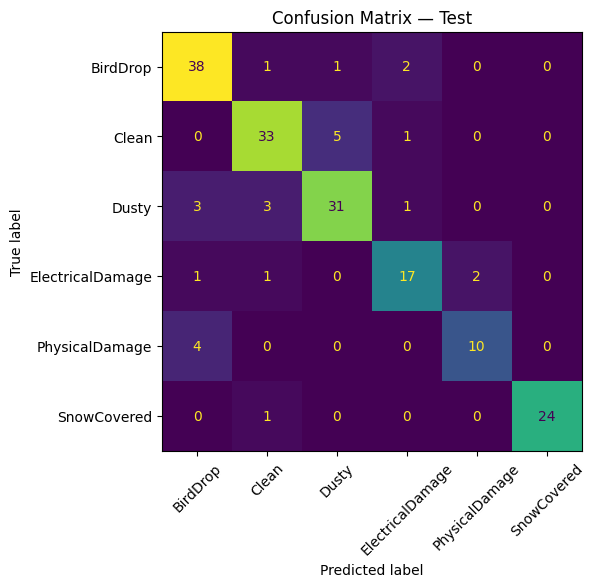

In [10]:
# test evaluation

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# loading best checkpoint
ckpt = torch.load(ARTIFACTS / "best_classifier.pt", map_location=device)
model.load_state_dict(ckpt["model"])

# test pass
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        preds = out.argmax(1)
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())
        del xb, yb, out, preds
gc.collect()

names = [idx_to_class[i] for i in range(num_classes)]
print(classification_report(y_true, y_pred, target_names=names, digits=4))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=names)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, xticks_rotation=45, values_format="d", colorbar=False)
plt.title("Confusion Matrix — Test")
plt.tight_layout()
plt.savefig(REPORTS / "confusion_matrix_test.png", dpi=160)
plt.show()

In [11]:
from PIL import Image
import numpy as np

infer_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

def predict_image(img_path: str):
    model.eval()
    with Image.open(img_path) as im:
        im = im.convert("RGB")
        t = infer_tfms(im).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(t)
            probs = out.softmax(dim=1).squeeze(0).cpu().numpy()
    pred_idx = int(np.argmax(probs))
    return idx_to_class[pred_idx], probs

# picking a random test image and printing prediction
import random
some_class = random.choice(list(idx_to_class.values()))
cand = list((SPLIT_DIR / "test" / some_class).glob("*"))
if cand:
    sample = random.choice(cand)
    label, probs = predict_image(str(sample))
    print("file:", sample.name, "| true:", some_class, "| pred:", label)
else:
    print("no test images found for a quick check.")

file: Electrical (34).jpg | true: ElectricalDamage | pred: ElectricalDamage
